In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from ast import literal_eval

from sklearn.model_selection import train_test_split

import IPython.display as ipd

import requests
import os
from varname import argname
from pydub import AudioSegment
import librosa

In [2]:
mp3s = pd.read_csv('data/collection_1_mp3s.csv', index_col=0)

In [3]:
mp3s['artists'] = mp3s['artists'].map(lambda x: literal_eval(x))

In [4]:
mp3s

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,6dJduZ358xg519NKuDy3gK,29,Zadnji Let,[Zembo Latifa],Venera,album,2020-09-25,https://i.scdn.co/image/ab67616d0000b273c0a12f...,270004,https://p.scdn.co/mp3-preview/20848b32d61466f8...
1,06AEBHCeGb3qP9xNmOBrlW,11,Profit (feat. Zonaman & Nickaveli),"[Young Scooter, Nickaveli, Zonaman]",Trap Hero,album,2019-11-08,https://i.scdn.co/image/ab67616d0000b273d3d750...,179409,https://p.scdn.co/mp3-preview/754bb0159255160b...
3,63jjIpEDcCwEtjYI4icdIn,20,Zer0style,[Rocks FOE],Zer0style,single,2021-06-18,https://i.scdn.co/image/ab67616d0000b2730b12b4...,201935,https://p.scdn.co/mp3-preview/caf6d678e1ab75cb...
4,0IvHcHx02BpoNIn9E9dK6G,17,Zeitmaschine,[Deetox Vengeance],Zeitmaschine,single,2020-09-25,https://i.scdn.co/image/ab67616d0000b273ba1176...,154350,https://p.scdn.co/mp3-preview/7cb5fd662d3e221b...
5,0rqudLpo4qtTvLykYXCZXl,37,Nie wiem czy to świat zwariował,[Polska Wersja],Powrót do przeszłości reedycja 2019,album,2019-12-06,https://i.scdn.co/image/ab67616d0000b273861eb6...,260826,https://p.scdn.co/mp3-preview/8e5eb4353bb69521...
...,...,...,...,...,...,...,...,...,...,...
21489,5ti4BRYkzUwkU5Y9Vx7GBQ,0,Aquí Ya Se Prendió,[Los Inquietos Del Norte],Otro Tequila Mas,album,2021-11-24,https://i.scdn.co/image/ab67616d0000b273180958...,162348,https://p.scdn.co/mp3-preview/d0c1b6b63015aa59...
21496,4r0p0IhfK7TEHFP6v89Vwt,0,Let's Kick His Ass!,"[Father, Zack Fox, Archibald Slim]",Let's Kick His Ass!,single,2021-11-24,https://i.scdn.co/image/ab67616d0000b27386d116...,229500,https://p.scdn.co/mp3-preview/3b6d31b4afdc6e66...
21497,3c8tkz9E6HbGMm4dwCi7An,4,Étoile 67,"[Striky, T.K]",Gravité,album,2021-07-23,https://i.scdn.co/image/ab67616d0000b273b7535e...,221538,https://p.scdn.co/mp3-preview/45f580ce158b3f1c...
21890,1IUhNvwC67VRb2j6Hcpeyf,13,Queen Bee,[VannDa],Queen Bee,single,2021-04-10,https://i.scdn.co/image/ab67616d0000b273996b98...,269264,https://p.scdn.co/mp3-preview/31d6963fa6fcb1b4...


In [5]:
mp3s[mp3s['track'] == "3 Headed Goat (feat. Lil Baby & Polo G)"]

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
1428,14c8arYQPMtxPcF4L4FYXC,46,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273fec5f2...,169531,https://p.scdn.co/mp3-preview/c9e5678e476335fb...
4297,5BSUxDJ8HcOWZD2KfExs7b,40,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b27390715e...,169531,https://p.scdn.co/mp3-preview/0270658a09c7cb98...
6133,6Tguhaf2uAe6OjRLsR2Tql,76,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2,album,2020-05-08,https://i.scdn.co/image/ab67616d0000b273f8558e...,169531,https://p.scdn.co/mp3-preview/6fca5999192d1a63...
14980,7J7UEZ08wc5aDsHgYpf8zI,6,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",Just Cause Y'all Waited 2 (Deluxe),album,2020-06-26,https://i.scdn.co/image/ab67616d0000b273bdce61...,169531,https://p.scdn.co/mp3-preview/fc4d8f65308509e2...
20285,4YEQWYhkJHgsm3Plul2FO2,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b273f9e7c1...,169531,https://p.scdn.co/mp3-preview/668a0f3e8babff9a...
21203,77C9MDQMGrzKlgsUwWzr6I,28,3 Headed Goat (feat. Lil Baby & Polo G),"[Lil Durk, Lil Baby, Polo G]",3 Headed Goat (feat. Lil Baby & Polo G),single,2020-05-07,https://i.scdn.co/image/ab67616d0000b27368df4d...,169531,https://p.scdn.co/mp3-preview/4c0c14e0309ed608...


In [6]:
# there are duplicate songs from different albums (single, album, etc.)
# if they have different popularity scores, that's still valuable info, however
mp3s[mp3s.duplicated(subset=['track','duration_ms','popularity'], 
                     keep=False)]['track'].value_counts()

6 'N the Mornin'                           6
9ja Hip Hop                                3
60%                                        2
6565                                       2
96 Freestyle                               2
Ring (feat. Young Thug)                    2
Face Off                                   2
Just Mellow - Norman Cook 7'' Remix        2
Sex Cells                                  2
Aries (feat. Peter Hook and Georgia)       2
80's - Instrumental - Remastered           2
Seven Day Hustle                           2
One Punch Wulf                             2
6itch remix - feat. Nitro                  2
Jazz Hands                                 2
Zero Survivors                             2
3 Headed Goat (feat. Lil Baby & Polo G)    2
8 Missed Calls                             2
SAME THING                                 2
Studio 54                                  2
50/50 Love                                 2
8 Figures                                  2
Name: trac

In [7]:
mp3s.shape

(16194, 10)

In [8]:
mp3s.drop_duplicates(subset=['track','duration_ms','popularity'], inplace=True)
mp3s.shape

(16168, 10)

In [9]:
# making train test holdout splits

X = mp3s.drop(columns=['popularity'])
y = mp3s['popularity']

X_pretr, X_holdout, y_pretr, y_holdout = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pretr, y_pretr, 
                                                    test_size=15/90, random_state=42)

datadict = {'data/X_train':X_train, 'data/X_test':X_test, 'data/X_holdout':X_holdout}

<AxesSubplot:>

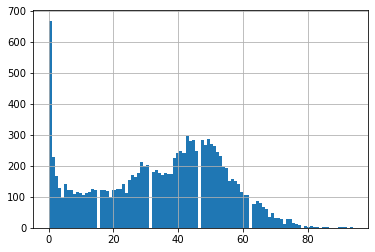

In [10]:
# 39 seems to be a good cutoff
y_train.hist(bins=100)

In [11]:
# defining popular as >= 39 and encoding (1 = popular)
y_train = y_train.map(lambda x: 1 if x >= 39 else 0)
y_train.value_counts(normalize=True)

0    0.512
1    0.488
Name: popularity, dtype: float64

In [12]:
y_test = y_test.map(lambda x: 1 if x >= 39 else 0)
y_test.value_counts(normalize=True)

0    0.516076
1    0.483924
Name: popularity, dtype: float64

In [13]:
y_holdout = y_holdout.map(lambda x: 1 if x >= 39 else 0)
y_holdout.value_counts(normalize=True)

0    0.506494
1    0.493506
Name: popularity, dtype: float64

In [14]:
def get_mp3(http, directory, name):
    try:
        r = requests.get(http, timeout=2)
        with open(f'{directory}/{name}.mp3', 'wb') as f:
            f.write(r.content)
        print(f'mp3 acquision: {name}.mp3')
    except:
        print(f'mp3 timeout: index {name}')

In [15]:
class LibrosaProcessing:
    def __init__(self, data, directory):
        self.data_ = data.copy()
        wd = !pwd
        self.directory_ = f'{wd[0]}/{directory}'
        if not os.path.exists(self.directory_):
            os.mkdir(self.directory_)

    def get_mp3(self):
        self.mp3_directory_ = f'{self.directory_}/mp3'
        if not os.path.exists(self.mp3_directory_):
            os.mkdir(self.mp3_directory_)
        self.data_['preview_url'].reset_index().apply(lambda x: get_mp3(x[1],
                                                                         self.mp3_directory_,
                                                                         x[0]), axis=1)
        print('mp3s acquired')
        
    def get_wav(self):
        self.mp3_directory_ = f'{self.directory_}/mp3'
        self.wav_directory_ = f'{self.directory_}/wav'
        if not os.path.exists(self.wav_directory_):
            os.mkdir(self.wav_directory_)
        for file in os.listdir(self.mp3_directory_):
            src = f'{self.mp3_directory_}/{file}'
            dest = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            AudioSegment.from_mp3(src).export(dest, format='wav')
            self.data_.loc[int(file.split(".")[0]),
                            'file_path'] = f'{self.wav_directory_}/{file.split(".")[0]}.wav'
            print(f'wav conversion: {file.split(".")[0]}.wav')
        self.wav_ = self.data_['file_path'].copy()

    def get_mel_spec_scaled(self):
        specs = []
        for count, song in enumerate(self.wav_, start=1):
            y, sr = librosa.load(song, duration=30)
            spec = librosa.power_to_db(librosa.feature.melspectrogram(y=y,sr=sr), ref=np.min)
            specs.append(spec[np.newaxis, ..., np.newaxis])
            print(f"wavs run: {count}/{len(self.wav_)}")
        mel_specs = np.concatenate(specs, axis=0)
        msmax = mel_specs.max()
        msmin = mel_specs.min()
        return (mel_specs - msmin)/(msmax - msmin)
    
    def mfcc(self):
        pass
#         librosa.        
#         return 

In [ ]:
mel_spec_datadict = {}
for directory, df in datadict.items():
    lp = LibrosaProcessing(df, directory)
    lp.get_mp3()
    lp.get_wav()
    modeldatadict[directory.split('/')[1]] = lp.get_mel_spec_scaled()

mp3 acquision: 2906.mp3
mp3 acquision: 4980.mp3
mp3 acquision: 5789.mp3
mp3 acquision: 17515.mp3
mp3 acquision: 18210.mp3
mp3 acquision: 3705.mp3
mp3 acquision: 1405.mp3
mp3 acquision: 777.mp3
mp3 acquision: 3568.mp3
mp3 acquision: 9465.mp3
mp3 acquision: 6036.mp3
mp3 acquision: 3873.mp3
mp3 acquision: 8272.mp3
mp3 acquision: 14917.mp3
mp3 acquision: 14683.mp3
mp3 acquision: 18493.mp3
mp3 acquision: 7976.mp3
mp3 acquision: 16240.mp3
mp3 acquision: 6120.mp3
mp3 acquision: 10892.mp3
mp3 acquision: 1454.mp3
mp3 acquision: 10863.mp3
mp3 acquision: 14653.mp3
mp3 acquision: 12767.mp3
mp3 acquision: 12831.mp3
mp3 acquision: 20521.mp3
mp3 acquision: 2909.mp3
mp3 acquision: 6078.mp3
mp3 acquision: 17119.mp3
mp3 acquision: 31.mp3
mp3 acquision: 5189.mp3
mp3 acquision: 21405.mp3
mp3 acquision: 8503.mp3
mp3 acquision: 11677.mp3
mp3 acquision: 21480.mp3
mp3 acquision: 18513.mp3
mp3 acquision: 2580.mp3
mp3 acquision: 5731.mp3
mp3 acquision: 3369.mp3
mp3 acquision: 4768.mp3
mp3 acquision: 8719.mp3
mp

### First Model - Multilayer Perceptron

In [ ]:
# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
mlp = keras.Sequential(name='mlp')

# flatten input 3D tensor to 1D
mlp.add(layers.Flatten(input_shape=input_shape))

# two hidden layers
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))

# output layer
mlp.add(layers.Dense(10, activation='softmax'))

# compile cnn
mlp.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
mlp.summary()

In [ ]:
# fit the model
history = mlp.fit(mel_spec_datadict['X_train'],
                  y_train,
                  epochs=60,
                  batch_size=30,
                  validation_data=(mel_spec_datadict['X_test'], y_test))

In [ ]:
### First Model - Multilayer Perceptron

We'll start off with a multilayer perceptron.

# set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# build sequentially
mlp = keras.Sequential(name='mlp')

# flatten input 3D tensor to 1D
mlp.add(layers.Flatten(input_shape=input_shape))

# two hidden layers
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(64, activation='relu'))

# output layer
mlp.add(layers.Dense(10, activation='softmax'))

# compile cnn
mlp.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

# take a look at model architecture
mlp.summary()

# fit the model
history = mlp.fit(X_train_mel_scaled,
                  y_train,
                  epochs=60,
                  batch_size=30,
                  validation_data=(X_test_mel_scaled, y_test))

In [ ]:
lp = LibrosaProcessing(X_train, 'data/X_train')
lp.get_wav()

In [ ]:
y, sr = librosa.load(lp.wav_.iloc[0],duration=30)
ipd.Audio(y,rate=sr)

In [ ]:
X_train_mel_spec = lp.mel_spec()

In [ ]:
# only timeout was index 9135
# X_train['preview_url'].reset_index().apply(lambda x: get_mp3(x[1], 'data/collection_1', 
#                                                              x[0]), axis=1)